In [3]:
import tensorflow as tf

In [4]:
from pathlib import Path

In [16]:
import matplotlib.pyplot as plt

In [44]:
import numpy as np

In [5]:
tf.random.set_seed(42)

In [6]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28,28]))

In [7]:
for _ in range(3):
    model.add(tf.keras.layers.Dense(100,activation="relu"))

In [8]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [9]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00025)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()


In [11]:
X_train_full.shape

(60000, 28, 28)

In [13]:
X_train_full.dtype

dtype('uint8')

In [17]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

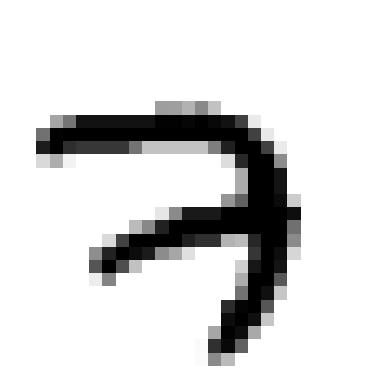

In [18]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [19]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [20]:
X_valid.shape

(5000, 28, 28)

In [21]:
y_valid.shape

(5000,)

In [22]:
X_test.shape

(10000, 28, 28)

In [25]:
rows = 5

In [26]:
cols = 10

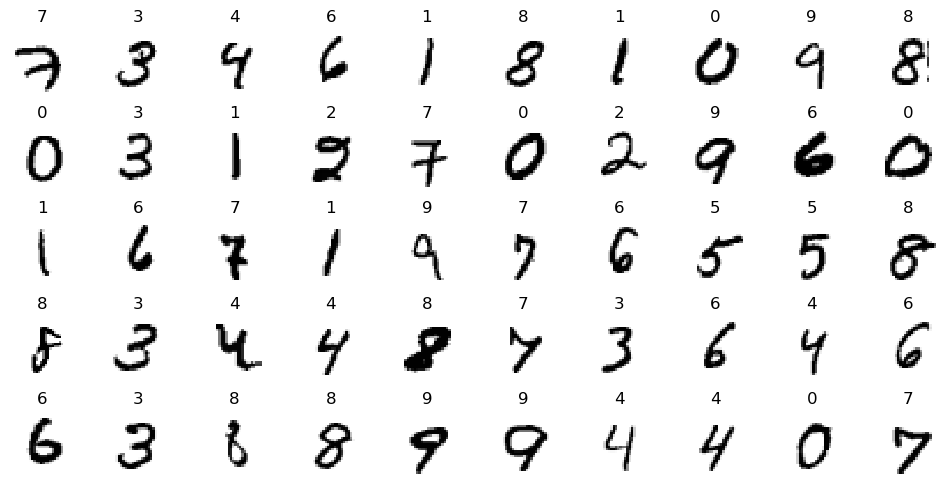

In [37]:
plt.figure(figsize=(cols * 1.2, rows * 1.2)) # Crea una nueva figura con un tamaño proporcional a la cantidad de columnas y filas (para que se vea bien en pantalla).
for row in range(rows):
    for col in range(cols):
        index = cols * row + col # Recorre cada celda de la cuadrícula y calcula el índice de la imagen correspondiente. Por ejemplo, si row=1 y col=2, index = 1*cols + 2.
        plt.subplot(rows, cols, index + 1) #Crea el subplot en la posición (index + 1) de la cuadrícula total rows x cols.
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest") #Muestra la imagen en escala de grises (colormap binary) sin interpolación (cada píxel se ve nítido).
        plt.axis("off") #Oculta los ejes
        plt.title(y_train[index]) #Muestra el numero correcto
plt.subplots_adjust(wspace=0.5, hspace=0.2) #Ajusta el espacio horizontal (wspace) y vertical (hspace) entre subplots para que no se solapen.
plt.show()

Let's build a simple dense network and find the optimal learning rate. We will need a callback to grow the learning rate at each iteration. It will also record the learning rate and the loss at each iteration:

In [39]:
K = tf.keras.backend
class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self,factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

- on_batch_end es un método que se ejecuta automáticamente al final de cada batch durante el entrenamiento de un modelo con model.fit(...).
- Forma parte del sistema de callbacks de Keras.
- Sirve para ejecutar código personalizado después de que se haya completado el entrenamiento de un batch.
- batch: número del batch actual dentro de la época.
- logs: un diccionario que contiene métricas recogidas durante el batch (por ejemplo: loss, accuracy, etc.)

La primer linea Obtiene el learning rate actual desde el optimizador del modelo (self.model.optimizer.learning_rate).
Convierte ese valor Tensor a un número (.numpy()).
Lo multiplica por el factor dado al constructor.
Resultado: un nuevo learning rate más grande o más pequeño, según el factor.

Luego asigna ese nuevo learning rate al optimizador. Esto cambia dinámicamente el learning rate del modelo para el próximo batch. Guarda el nuevo learning rate en una lista para poder graficarlo o analizarlo después del entrenamiento. Agrega el loss (pérdida) de este batch a otra lista. Sirve para ver cómo evoluciona el error junto con el learning rate.

Un tensor es una estructura de datos que generaliza los conceptos de escalar (número), vector (lista de números) y matriz (tabla de números) a cualquier número de dimensiones. En bibliotecas como TensorFlow, los tensores son los objetos fundamentales que representan datos: pueden tener desde cero dimensiones (un número) hasta muchas dimensiones (por ejemplo, una imagen en color representada como un tensor 3D: alto × ancho × canales). Son especialmente útiles porque pueden ejecutarse de forma eficiente en CPUs, GPUs o TPUs, y son la base para todas las operaciones matemáticas en redes neuronales.

En TensorFlow, self.model.optimizer.learning_rate es un tensor, no un número Python común. Esto permite que TensorFlow mantenga el valor del learning rate como parte del grafo computacional. Sin embargo, si necesitás usar ese valor fuera del grafo (por ejemplo, para imprimirlo o modificarlo con operaciones normales de Python), debés convertirlo a un número real. Eso es lo que hace .numpy() — extrae el valor del tensor y lo convierte en un tipo de dato nativo de NumPy (como un float), permitiendo manipularlo como si fuera un número común en Python.

In [45]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [46]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [48]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [49]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.5875 - val_loss: nan - val_accuracy: 0.0958


Ahora se hace una grafica de pérdida vs learning rate

Text(0, 0.5, 'Loss')

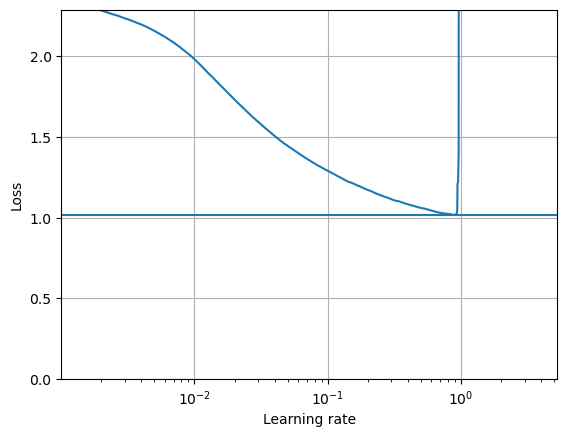

In [61]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale("log")
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

Este código utiliza Matplotlib para graficar cómo varía la pérdida (loss) del modelo en función del learning rate (learning rate), después de haber entrenado el modelo usando un callback personalizado que modifica el learning rate exponencialmente en cada batch (como ExponentialLearningRate). El objetivo principal de esta gráfica es ayudarte a encontrar el rango óptimo de valores para el learning rate, una técnica muy útil conocida como Learning Rate Finder. La curva resultante suele mostrar que, a medida que el learning rate aumenta, la pérdida primero mejora (disminuye) y luego empeora drásticamente. Observar este comportamiento permite elegir un learning rate que esté justo antes del punto donde la pérdida empieza a explotar.

La gráfica usa una escala logarítmica en el eje X (set_xscale("log")) porque los valores del learning rate suelen cambiar en órdenes de magnitud (por ejemplo, de 1e-7 a 1). Una escala lineal no representaría bien esa variación; con escala logarítmica, se pueden ver claramente tanto los valores muy pequeños como los grandes en un mismo gráfico. La línea horizontal (hlines(...)) marca el valor mínimo alcanzado por la pérdida, como referencia visual. Por último, plt.axis([...]) limita los valores que se muestran en los ejes: el eje X se acota usando min y max del learning rate, mientras que el eje Y va de 0 hasta el primer valor de pérdida (expon_lr.losses[0]), probablemente para evitar mostrar valores de pérdida extremadamente grandes que distorsionen la escala. En conjunto, esta visualización permite seleccionar un buen valor inicial para el learning rate antes de un entrenamiento más largo.

In [62]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Se resetan los valores y la semilla, para no alterar el modelo con el proceso de encontrar los learning rates

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [65]:
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=3e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [66]:
run_index = 1 # increment this at every run
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [68]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0922 - accuracy: 0.9717 - val_loss: 0.0863 - val_accuracy: 0.9750
Epoch 2/100
 138/1719 [=>............................] - ETA: 1s - loss: 0.0508 - accuracy: 0.9826

/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1719/1719 [==============================] - 2s 1ms/step - loss: 0.0672 - accuracy: 0.9790 - val_loss: 0.0855 - val_accuracy: 0.9776
Epoch 3/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0493 - accuracy: 0.9838 - val_loss: 0.0687 - val_accuracy: 0.9814
Epoch 4/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0379 - accuracy: 0.9877 - val_loss: 0.0839 - val_accuracy: 0.9774
Epoch 5/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0321 - accuracy: 0.9894 - val_loss: 0.0800 - val_accuracy: 0.9802
Epoch 6/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.0675 - val_accuracy: 0.9834
Epoch 7/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0204 - accuracy: 0.9929 - val_loss: 0.0904 - val_accuracy: 0.9790
Epoch 8/100
1719/1719 [==============================] - 2s 1ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0802 - val_accuracy: 0.98

In [70]:
%load_ext tensorboard
%tensorboard --logdir=./my_mnist_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.